OBU Analysis

Update
1. 分析使用一年份資料，僅保留客戶最新資訊欄位
2. 與兆豐討論後移除變數如下
    - REPORT_FG
    - CDD_STATUS
    - RISK_LEVEL
3. 與兆豐討論後若模型選中需移除之變數如下:
    - CMFCUS1_ADR_CNT
    - CMFCUS1_PURPOSE_NA_TYPE
    - CONFIRM_TYPE_1
    - LN_TYPE_NA_TYPE

In [1]:
# Module 匯入
import os.path
import pandas as pd
import numpy as np
from datetime import date

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LogisticRegression # logistic regression
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import ShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve #P-R Curve
from sklearn import metrics
from sklearn.model_selection import GridSearchCV #Hyperparameters

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

#### 1. Data Import & Cleaning

In [2]:
# 資料匯入

# EY補充
# 此處路徑需更新為最新資料存放路徑

OBU = pd.read_csv(r"/home/bigdata93601/DB Result/OBU_result_one_year.csv", dtype=str)
OBU['CYC_MN'] = pd.to_datetime(OBU['CYC_MN'])

In [4]:
# 刪除FINAL_CRR為空值的row
OBU = OBU[OBU['FINAL_CRR'].notna()]
OBU.reset_index(inplace=True)

# CUST_DUP_NO 空值補0
OBU['CUST_DUP_NO'] = OBU['CUST_DUP_NO'].fillna('0')

# SAR: 非 Y即 N
OBU['SAR'] = np.where(OBU['SAR'] == 'Y', 'Y', 'N')

##### Drop Duplicated data (New Version)
目的: 僅保留在資訊層面最新之帳戶

In [8]:
# 僅保留客戶最新資訊欄位
use_cols = ['CUST_ID', 'CUST_DUP_NO'] + ['SAR']
OBU = OBU.sort_values('CYC_MN', ascending=False).drop_duplicates(subset=use_cols, keep='first')
OBU.reset_index(inplace=True, drop=True)

In [9]:
OBU['CYC_MN'].value_counts(dropna=False).sort_index()

2019-09-01       96
2019-10-01       87
2019-11-01       81
2019-12-01       52
2020-01-01       59
2020-02-01       55
2020-03-01       63
2020-04-01       52
2020-05-01       64
2020-06-01       75
2020-07-01       67
2020-08-01    16672
Name: CYC_MN, dtype: int64

#### 2. 變數轉換

##### 2.1 類別型變數  
- 原始欄位為類別型變數

In [10]:
# EY補充
# 新增欄位的情況下，將類別型變數轉換為Y/N的資料格式。
# 下面範例將以df代表輸入資料，NEW_COLUMN代表新增欄位
# 
# 範例一
# 新增欄位的資料內容為["V", Nan, "V", "V", Nan, ... , "V"]；欲將V轉換為Y，空值(Nan)轉換為N。
# df["NEW_COLUMN"] = np.where(df["NEW_COLUMN"] == "V", "Y", "N")
#
# 範例二
# 新增欄位的資料內容為["Y", "DELAY", "Y", Nan, "Y", ... , "N"]；欲將非Y/N轉換為N，其餘資料維持原狀。
# df["NEW_COLUMN"] = np.where(df["NEW_COLUMN"].isin(["Y", "N"], df["NEW_COLUMN"], "N"))
#
# 範例三
# 新增欄位的資料內容為["01", "02", "03", "04", ..., "01"]；欲將01-02轉換為Y，03-04轉換為N。
# df["NEW_COLUMN"] = df["NEW_COLUMN"].map({"01": "Y", "02": "Y", "03": "N", "04": "N"})


# 類別型變數轉換
# CMFCUS1_AML_BUSINESS
def apply_CMFCUS1_AML_BUSINESS(series):
    input = series['CMFCUS1_AML_BUSINESS']
    if (input in ['01', '02', '03', '04', '05', '06', '07', '08']):
        return 'Y'
    else:
        return 'N'

OBU['CMFCUS1_AML_BUSINESS'] = OBU.apply(apply_CMFCUS1_AML_BUSINESS, axis=1)


for i in ['DP_FG', 'LN_FG', 'IX_FG', 'BD_FG', 'FD_FG', 'WM_FG', 'TR_FG', 'EB_FG', 'CD_FG', 'OT_FG']:
    OBU[i] = np.where(OBU[i] == 'V', 'Y', 'N')


# CMFCUS25_AE_TYPE
# Turn Na into 'N'; other into 'Y'
OBU['CMFCUS25_AE_TYPE'] = np.where((OBU["CMFCUS25_AE_TYPE"].isin(['1', '2', '3', '4', '5', '6', '7'])), 'Y', 'N')


# 類別型變數名錄
# 非 (Y or N) 即 N

X_Categorical = ['CMFCUS1_VIP_CODE', 'CMFCUS1_BUSINESS_FLAG', 'CMFCUS1_NOTAX_FLAG', 'CMFCUS1_FINANCIAL_ACT', 
                 'CMFCUS1_AML_BUSINESS', 'DP_FG', 'LN_FG', 'IX_FG', 'BD_FG', 'FD_FG', 'WM_FG', 'TR_FG', 'EB_FG', 
                 'CD_FG', 'OT_FG', 'TRUST_YN', 'CONFIRM_YN', 'COMPLEX_CS_FG', 'AUTHORIZED', 'BEARER_SHARE', 
                 'ISSUE_BEARER', 'SOLE_CORP', 'TRUST_HOLDER', 'CUST_PANA', 'CUST_THIRD', 'CUST_ADVRS', 
                 'CUST_BAHA', 'CUST_PARA', 'CMFCUS25_AE_TYPE', 'CMFCUS25_FOREIGN_COMPANY', 'CMFCUS25_FOREIGN_ENTITY', 
                 'CMFCUS25_CERTI_FLAG', 'CMFCUS25_TAXFREE_FLAG', 'CMFCUS25_CREATIVE_FLAG', 'CMFCUS25_OSU_FLAG', 
                 'CMFCUS25_PUBLIC_CMPY']

for x in X_Categorical:
    OBU[x] = np.where(~OBU[x].isin(['Y', 'N']), 'N', OBU[x])


- 計算後轉換為類別型變數

In [11]:
# EY補充
# 計算後轉換為類別型變數之欄位需要由使用者自行定義分類條件
# 下面範例將以df代表輸入資料；NEW_COLUMN_代表新增欄位
# 
# 範例一
# 新增欄位的資料內容為["3", "2", "1", "0", Nan, ... , "2"]
# 使用者欲將數量大於等於1轉換為Y，其餘轉換為N。
# df["NEW_COLUMN"] = np.where(df["NEW_COLUMN"].fillna("0").astype(int) >= 1, "Y", "N")


# 變數計算
# PEP_COUNT
test = OBU[(OBU['PEP_1'] == 'Y') | (OBU['PEP_2'] == 'Y') | (OBU['PEP_3'] == 'Y') | (OBU['PEP_4'] == 'Y')][['PEP_1', 'PEP_2', 'PEP_3', 'PEP_4']]
test2 = test.apply(pd.Series.value_counts, axis=1).fillna(0)
OBU['PEP_COUNT'] = 0
OBU.loc[test2.index, 'PEP_COUNT'] = test2['Y']

# REL_ADVERS_COUNT
test = OBU[(OBU['REL_ADVRS_1'] == 'Y') | (OBU['REL_ADVRS_2'] == 'Y') | (OBU['REL_ADVRS_3'] == 'Y') | (OBU['REL_ADVRS_4'] == 'Y') | (OBU['REL_ADVRS_5'] == 'Y') | 
          (OBU['REL_ADVRS_6'] == 'Y') | (OBU['REL_ADVRS_7'] == 'Y') | (OBU['REL_ADVRS_8'] == 'Y') | (OBU['REL_ADVRS_9'] == 'Y') | (OBU['REL_ADVRS_10'] == 'Y') |
          (OBU['REL_ADVRS_11'] == 'Y') | (OBU['REL_ADVRS_12'] == 'Y') | (OBU['REL_ADVRS_13'] == 'Y') | (OBU['REL_ADVRS_14'] == 'Y') | (OBU['REL_ADVRS_15'] == 'Y') | 
          (OBU['REL_ADVRS_16'] == 'Y') | (OBU['REL_ADVRS_17'] == 'Y') | (OBU['REL_ADVRS_18'] == 'Y') | (OBU['REL_ADVRS_19'] == 'Y') | (OBU['REL_ADVRS_20'] == 'Y')
          ][['REL_ADVRS_1', 'REL_ADVRS_2', 'REL_ADVRS_3', 'REL_ADVRS_4', 'REL_ADVRS_5', 'REL_ADVRS_6', 'REL_ADVRS_7', 'REL_ADVRS_8', 
            'REL_ADVRS_9', 'REL_ADVRS_10', 'REL_ADVRS_11', 'REL_ADVRS_12', 'REL_ADVRS_13', 'REL_ADVRS_14', 'REL_ADVRS_15', 'REL_ADVRS_16', 
            'REL_ADVRS_17', 'REL_ADVRS_18', 'REL_ADVRS_19', 'REL_ADVRS_20']] 
test2 = test.apply(pd.Series.value_counts, axis=1).fillna(0)
OBU['REL_ADVERS_COUNT'] = 0
OBU.loc[test2.index, 'REL_ADVERS_COUNT'] = test2['Y']

# REL_PEPS_COUNT
test = OBU[(OBU['REL_PEPS_1'] == 'Y') | (OBU['REL_PEPS_2'] == 'Y') | (OBU['REL_PEPS_3'] == 'Y') | (OBU['REL_PEPS_4'] == 'Y') | (OBU['REL_PEPS_5'] == 'Y') | 
          (OBU['REL_PEPS_6'] == 'Y') | (OBU['REL_PEPS_7'] == 'Y') | (OBU['REL_PEPS_8'] == 'Y') | (OBU['REL_PEPS_9'] == 'Y') | (OBU['REL_PEPS_10'] == 'Y') |
          (OBU['REL_PEPS_11'] == 'Y') | (OBU['REL_PEPS_12'] == 'Y') | (OBU['REL_PEPS_13'] == 'Y') | (OBU['REL_PEPS_14'] == 'Y') | (OBU['REL_PEPS_15'] == 'Y') | 
          (OBU['REL_PEPS_16'] == 'Y') | (OBU['REL_PEPS_17'] == 'Y') | (OBU['REL_PEPS_18'] == 'Y') | (OBU['REL_PEPS_19'] == 'Y') | (OBU['REL_PEPS_20'] == 'Y')
          ][['REL_PEPS_1', 'REL_PEPS_2', 'REL_PEPS_3', 'REL_PEPS_4', 'REL_PEPS_5', 'REL_PEPS_6', 'REL_PEPS_7', 'REL_PEPS_8', 
            'REL_PEPS_9', 'REL_PEPS_10', 'REL_PEPS_11', 'REL_PEPS_12', 'REL_PEPS_13', 'REL_PEPS_14', 'REL_PEPS_15', 'REL_PEPS_16', 
            'REL_PEPS_17', 'REL_PEPS_18', 'REL_PEPS_19', 'REL_PEPS_20']] 
test2 = test.apply(pd.Series.value_counts, axis=1).fillna(0)
OBU['REL_PEPS_COUNT'] = 0
OBU.loc[test2.index, 'REL_PEPS_COUNT'] = test2['Y']


# 非數字即 0
X_Numeric = ['CMFCUS1_MPHONE_CNT', 'CMFCUS1_OPHONE_CNT', 
             'PEP_COUNT', 'REL_ADVERS_COUNT', 'REL_PEPS_COUNT']

for col in X_Numeric:
    OBU[col] = OBU[col].fillna(0)
    

# 依條件轉換為類別型變數

# CMFCUS1_MPHONE_CNT; 
OBU['CMFCUS1_MPHONE_CNT'] = OBU['CMFCUS1_MPHONE_CNT'].astype(int)
# Create new column
OBU['CMFCUS1_MPHONE_CNT_THR_2'] = np.where(OBU['CMFCUS1_MPHONE_CNT'] >= 2, 'Y', 'N')

# CMFCUS1_OPHONE_CNT
OBU['CMFCUS1_OPHONE_CNT'] = OBU['CMFCUS1_OPHONE_CNT'].astype(int)
# Create new column
OBU['CMFCUS1_OPHONE_CNT_THR_2'] = np.where(OBU['CMFCUS1_OPHONE_CNT'] >= 2, 'Y', 'N')

# PEP_COUNT
# Create new column
OBU['PEP_COUNT_THR_1'] = np.where(OBU['PEP_COUNT'] >=1, 'Y', 'N')

# REL_ADVERS_COUNT
# Create new column
OBU['REL_ADVERS_COUNT_THR_1'] = np.where(OBU['REL_ADVERS_COUNT'] >=1, 'Y', 'N')

# REL_PEPS_COUNT
# Create new column
OBU['REL_PEPS_COUNT_THR_1'] = np.where(OBU['REL_PEPS_COUNT'] >=1, 'Y', 'N')

# 更新類別型變數名錄
X_Categorical = X_Categorical + ['CMFCUS1_MPHONE_CNT_THR_2', 'CMFCUS1_OPHONE_CNT_THR_2', 
                                 'PEP_COUNT_THR_1', 'REL_ADVERS_COUNT_THR_1', 'REL_PEPS_COUNT_THR_1']


In [ ]:
# 將Y/N轉換為1/0以方便後面模型執行計算
for col in X_Categorical:
    OBU[col] = LabelEncoder().fit_transform(OBU[col])

##### 2.2 順序型變數

In [12]:
# EY補充
# 新增欄位的情況下，將順序型變數轉換為數字順序(1, 2, 3,...)。
# 下面範例將以df代表輸入資料，NEW_COLUMN代表新增欄位
# 
# 範例一
# 新增欄位的資料內容為["L", "M", "H", Nan, ..., "H"]；欲將H/M/L轉換為3/2/1，空值(Nan)轉換為1。
# df["NEW_COLUMN"] = df["NEW_COLUMN"].map({"H": "3", "M": "2", "L": "1"}).fillna("1")


# 順序型變數轉換
# Remember that changing NA value into the lowest ranking in ordinal variables might cause issue and affect the model performation
# It should be adjusted to dummy variables in the second proposal.

# CMFCUS1_BUSINESS_CODE
BUSINESS_CODE_TABLE = pd.read_csv(r"/home/bigdata93601/DB Result/BUSINESS_CODE_TABLE.csv", dtype=str) #行業編號對照風險等級表

# Create dictionary
BUSINESS_CODE_dict = {'L': BUSINESS_CODE_TABLE[BUSINESS_CODE_TABLE['RISK']=='L']['CODE'].tolist(),
                      'M': BUSINESS_CODE_TABLE[BUSINESS_CODE_TABLE['RISK']=='M']['CODE'].tolist(),
                      'H': BUSINESS_CODE_TABLE[BUSINESS_CODE_TABLE['RISK']=='H']['CODE'].tolist()}
# Inverse dictionary
BUSINESS_CODE_dict = {c: r for r, code in BUSINESS_CODE_dict.items() for c in code}

OBU['CMFCUS1_BUSINESS_CODE'].replace(BUSINESS_CODE_dict, inplace=True)
# Nan轉為L
OBU['CMFCUS1_BUSINESS_CODE'] = np.where(~OBU["CMFCUS1_BUSINESS_CODE"].isin(['H', 'M', 'L']), 'L', OBU['CMFCUS1_BUSINESS_CODE'])
OBU['CMFCUS1_BUSINESS_CODE'] = OBU['CMFCUS1_BUSINESS_CODE'].map({"H": "3", "M": "2", "L": "1"})


# LOCATION_CD & HEAD_OFFICE_CD 
# Create a new column: Nation_Risk to select the higher one between the two columns
NationRisk_Table = pd.read_excel(r"/home/bigdata93601/EY/NationRisk_Table.xlsx", dtype=str)

NationRisk_dict = {'1':NationRisk_Table[NationRisk_Table['洗錢風險評等']=='L']['國家代碼'].tolist(),
                   '2': NationRisk_Table[NationRisk_Table['洗錢風險評等']=='ML']['國家代碼'].tolist(),
                   '3': NationRisk_Table[NationRisk_Table['洗錢風險評等']=='M']['國家代碼'].tolist(),
                   '4': NationRisk_Table[NationRisk_Table['洗錢風險評等']=='MH']['國家代碼'].tolist(),
                   '5': NationRisk_Table[NationRisk_Table['洗錢風險評等']=='H']['國家代碼'].tolist()}

# Inverse dictionary
NationRisk_dict = {c: r for r, code in NationRisk_dict.items() for c in code}

OBU['LOCATION_CD'].replace(NationRisk_dict, inplace=True)
OBU['HEAD_OFFICE_CD'].replace(NationRisk_dict, inplace=True)
# Nan or no matching 轉為H
OBU['LOCATION_CD'] = np.where(~OBU['LOCATION_CD'].isin(['1', '2', '3', '4', '5']), '5', OBU['LOCATION_CD'])
OBU['HEAD_OFFICE_CD'] = np.where(~OBU['HEAD_OFFICE_CD'].isin(['1', '2', '3', '4', '5']), '5', OBU['HEAD_OFFICE_CD'])

OBU['NATION_RISK'] = OBU[['LOCATION_CD', 'HEAD_OFFICE_CD']].max(axis=1).astype(int).astype(str)

# AMT_RANGE
# Nan 轉為0
OBU['AMT_RANGE'] = np.where(~OBU["AMT_RANGE"].isin(['1', '2', '3']), '0', OBU['AMT_RANGE'])

# OBU_ANNUAL_INCOME
# Nan 轉為0
OBU['OBU_ANNUAL_INCOME'] = np.where(~OBU["OBU_ANNUAL_INCOME"].isin(['1', '2', '3']), '0', OBU['OBU_ANNUAL_INCOME'])

# CMFCUS25_SP_RATING
OBU['CMFCUS25_SP_RATING'] = OBU['CMFCUS25_SP_RATING'].map({np.nan: 1, 'D': 2, 'SD': 3, 'R': 4, 'CCC-': 5, 'CCC': 6, 
                                                           'CCC+': 7, 'B-': 8, 'B': 9, 'B+': 10, 'BB-': 11, 'BB': 12, 
                                                           'BB+': 13, 'BBB-': 14, 'BBB': 15, 'BBB+': 16, 'A-': 17, 
                                                           'A': 18, 'A+': 19, 'AA-': 20, 'AA': 21, 'AA+': 22, 'AAA': 23})

# CMFCUS25_MOODYS_RATING
# Moody's has assigned (P)A1 ratings to the 1 billion preferred securities shelf registration of five Travelers Capital trusts
# Here I'll take it as the same level with A1
OBU['CMFCUS25_MOODYS_RATING'] = np.where(OBU['CMFCUS25_MOODYS_RATING'] == '(P)A1', 'A1', OBU['CMFCUS25_MOODYS_RATING'])

OBU['CMFCUS25_MOODYS_RATING'] = np.where(OBU['CMFCUS25_MOODYS_RATING'] == 'A3-', 'A3', OBU['CMFCUS25_MOODYS_RATING']) #Fix typo

OBU['CMFCUS25_MOODYS_RATING'] = OBU['CMFCUS25_MOODYS_RATING'].map({np.nan: 1, 'D': 2, 'C': 3, 'Ca': 4, 'Caa3': 5, 'Caa2': 6, 
                                                                   'Caa1': 7, 'B3': 8, 'B2': 9, 'B1': 10, 'Ba3': 11, 'Ba2': 12, 
                                                                   'Ba1': 13, 'Baa3': 14, 'Baa2': 15, 'Baa1': 16, 'A3': 17, 
                                                                   'A2': 18, 'A1': 19, 'Aa3': 20, 'Aa2': 21, 'Aa1': 22, 'Aaa': 23})

# CMFCUS25_SRT_SP_RATING
OBU['CMFCUS25_SRT_SP_RATING'] = OBU['CMFCUS25_SRT_SP_RATING'].map({np.nan: 1, 'D': 2, 'C': 3, 'B': 4, 'A-3': 5, 
                                                                   'A-2': 6, 'A-1': 7, 'A-1+': 8})

# CMFCUS25_SRT_MOODYS_RATING
OBU['CMFCUS25_SRT_MOODYS_RATING'] = OBU['CMFCUS25_SRT_MOODYS_RATING'].map({np.nan: 1, 'P-3': 2, 'P-2': 3, 'P-1': 4})

# CMFCUS25_SRT_FITCH_RATING
OBU['CMFCUS25_SRT_FITCH_RATING'] = np.where(OBU['CMFCUS25_SRT_FITCH_RATING'] == 'F2-', 'F2', OBU['CMFCUS25_SRT_FITCH_RATING']) #Fix typo

OBU['CMFCUS25_SRT_FITCH_RATING'] = OBU['CMFCUS25_SRT_FITCH_RATING'].map({np.nan: 1, 'D': 2, 'C': 3, 'B': 4, 'F3': 5, 
                                                                         'F2': 6, 'F1': 7, 'F1+': 8})

# 順序型變數名錄
X_Ordinal = ['CMFCUS1_BUSINESS_CODE', 'NATION_RISK', 'AMT_RANGE', 
             'OBU_ANNUAL_INCOME', 'CMFCUS25_SP_RATING', 'CMFCUS25_MOODYS_RATING', 
             'CMFCUS25_SRT_SP_RATING', 'CMFCUS25_SRT_MOODYS_RATING', 'CMFCUS25_SRT_FITCH_RATING']


##### 2.3 啞變數(Dummy)

In [16]:
# EY補充
# 新增欄位的情況下，確認啞變數資料內容。
# 此階段僅需確保啞變數內容正確，one hot encoding的部分會在後面執行。
# 需要注意的地方為若欲將空值作為一個單獨的類別，則建議將空值轉換為字串(EX: "NA_TYPE")。
#
# 下面範例將以df代表輸入資料，NEW_COLUMN代表新增欄位
#
# 範例一
# 新增欄位的資料內容為["A", "C", "1", "3", Nan,..., Nan]；欲將空值(Nan)轉換為"NA_TYPE"，其餘內容保持不變。
# df["NEW_COLUMN"] = np.where(df["NEW_COLUMN"].isna(), "NA_TYPE", df["NEW_COLUMN"])
#
# 範例二
# 新增欄位的資料內容為["A", "C", "B", "DELAY", "Q", Nan, ..., "A"]；欲將A, B, C, Q保留，其餘內容分類為空值類別。
# df["NEW_COLUMN"] = np.where(df["NEW_COLUMN"].isin(["A", "B", "C", "Q"]), df["NEW_COLUMN"], "NA_TYPE")


# Dummy變數轉換

# CMFCUS1_BIRTH_DATE
OBU['CMFCUS1_BIRTH_DATE'] = pd.to_datetime(OBU['CMFCUS1_BIRTH_DATE'], errors='coerce') #if out of bounds then return NAT

def calculate_age(born):
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

OBU['CMFCUS1_BIRTH_DATE'] = OBU['CMFCUS1_BIRTH_DATE'].apply(calculate_age)

def apply_age(Series):
    input = Series
    if input < 3:
        return '0-3'
    elif (input >= 3) & (input < 5):
        return '3-5'
    elif (input >= 5) & (input < 10):
        return '5-10'
    elif input >= 10:
        return '>10'
    else:
        'NA_TYPE'

OBU['CMFCUS1_BIRTH_DATE'] = OBU['CMFCUS1_BIRTH_DATE'].apply(apply_age)


# CMFCUS1_Q_ID
# 00, 01, 03, 10, 36, 49, 99都歸於NA_TYPE
OBU['CMFCUS1_Q_ID'] = np.where(OBU["CMFCUS1_Q_ID"].isin(['00', '01', '03', '10', '36', '49', '99', 'ZZ', np.nan]), 
                               'NA_TYPE', OBU["CMFCUS1_Q_ID"])

# CMFCUS1_PURPOSE, CMFCUS1_DERIVATIVE, CMFCUS1_TITLE_CODE, LN_TYP, CONFIRM_TYPE, CMFCUS25_BRANCH
# NA改成NA_TYPE
for i  in ['CMFCUS1_JOB_TITLE', 'CMFCUS1_PURPOSE', 'CMFCUS1_DERIVATIVE', 'CMFCUS1_TITLE_CODE', 'LN_TYP', 'CONFIRM_TYPE', 'CMFCUS25_BRANCH', 'CMFCUS25_FORE_CASH_FLAG']:
    OBU[i] =np.where(OBU[i].isna(), 'NA_TYPE', OBU[i])

# CORP_TYPE
# 根據兆豐回覆: 共12類
# 1~9, A, Z, Nan: NA_TYPE

OBU['CORP_TYPE'] = np.where(OBU['CORP_TYPE'].isin(['1', '2', '3', '4', '5', '6', '7', '8', '9', 'Z', 'A']), OBU['CORP_TYPE'], 'NA_TYPE')


# Dummy變數名錄
X_Dummy = ['CMFCUS1_BIRTH_DATE', 'CMFCUS1_JOB_TITLE', 'CMFCUS1_Q_ID','CMFCUS1_PURPOSE', 'CMFCUS1_DERIVATIVE', 'CMFCUS1_TITLE_CODE', 
           'CUST_TYP', 'LN_TYP', 'CONFIRM_TYPE', 'CORP_TYPE', 'CMFCUS25_BRANCH', 'CMFCUS25_FORE_CASH_FLAG', 'CHANNEL']


#### 3. Variable Selection(變數篩選)

##### 3.1 WOE & IV

In [17]:
#變數篩選：計算 WOE & Information Value
# Python has no package calculating WOE & IV

def iv_woe(data, target, bins=10, show_woe=False):
    
    # Empty Dataframe
    newDF, woeDF = pd.DataFrame(), pd.DataFrame()
    
    # Extract Column Names
    cols = data.columns
    
    # Run WOE & IV on all X variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') & (len(np.unique(data[ivars])) > 10):
            binned_x = pd.qcut(data[ivars], bins, duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        
        d = d0.groupby('x', as_index=False).agg({'y': ['count', 'sum']})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events'] / d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        #print("Information value of " + ivars + " is " + str(round(d['IV'].sum(), 6)))
        
        temp = pd.DataFrame({"Variable": [ivars], "IV": [d['IV'].sum()]}, columns=["Variable", "IV"])
        newDF = pd.concat([newDF, temp], axis=0)
        woeDF = pd.concat([woeDF, d], axis=0)
        
        # Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF


data = OBU[X_Categorical + X_Ordinal + X_Dummy + ['SAR']]
data['SAR'] = LabelEncoder().fit_transform(data['SAR']) # Turn y into [0, 1]
# 轉換dummy變數
for each in X_Dummy:
    dummies = pd.get_dummies(data.loc[:, each], prefix=each)
    data = pd.concat([data, dummies], axis=1)

# Delete original dummy variable columns
data = data.drop(X_Dummy, axis=1)

iv, woe = iv_woe(data=data, target='SAR', bins=10, show_woe=False)

/opt/microsoft/mlserver/9.4.7/runtime/python/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [18]:
# 篩選 IV值大於0.1之變數
# 0.02-0.1: the predictor has only a weak relationship to the Goods/Bads odds ration
# 0.1-0.3: the predictor has a medium strength relationship to the Goods/Bads odds ration
# 0.3-0.5: the predictor has a strong relationship to the Goods/Bads odds ration
# >0.5: suspicious relationship

# Select variable with IV larger than 0.1 
print(iv[iv["IV"] > 0.1])

                  Variable        IV
0    CMFCUS1_FINANCIAL_ACT  0.621225
0                    LN_FG  0.129267
0                    IX_FG  0.626912
0                    EB_FG  0.165231
0               CONFIRM_YN  0.885339
0               CUST_THIRD  0.161200
0      CMFCUS25_CERTI_FLAG  0.343966
0                AMT_RANGE  0.784333
0        OBU_ANNUAL_INCOME  0.449471
0        CMFCUS1_PURPOSE_E  0.120352
0  CMFCUS1_PURPOSE_NA_TYPE  0.405848
0           LN_TYP_NA_TYPE  0.135056
0           CONFIRM_TYPE_1  0.706230
0     CONFIRM_TYPE_NA_TYPE  0.885339
0              CORP_TYPE_4  0.144603
0        CORP_TYPE_NA_TYPE  0.643870
0              CORP_TYPE_Z  0.897411
0        CMFCUS25_BRANCH_0  0.592172
0  CMFCUS25_BRANCH_NA_TYPE  0.680475


##### 3.2 VIF

In [ ]:
# 紀錄因法遵考量需移除之變數
'''
CMFCUS1_Q_ID_4: 持居留證之外國人 不應存在
CMFCUS1_PURPOSE_NA_TYPE 若有選中須從模型移除
CONFIRM_TYPE_1 若有選中須從模型移除
LN_TYPE_NA_TYPE 若有選中須從模型移除
'''

In [19]:
# 變數篩選：計算共線性，移除VIF大於10之變數
# check IV > 0.1 variables VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Variables with VIF over 10 should be checked 
# Drop some columns with high VIF(The variables are changeable to find the best answer) 
X_trans = data[pd.Series.tolist(iv.loc[iv['IV'] >= 0.1, 'Variable'])]

# EY補充
# 下面Code會先選擇移除不適用於分析之欄位
# 透過移除/新增欄位名稱即可進行修改
X_trans = X_trans.drop(['CONFIRM_YN', 'CONFIRM_TYPE_NA_TYPE', 'LN_TYP_NA_TYPE', 'CONFIRM_TYPE_1', 'CMFCUS1_PURPOSE_NA_TYPE',
                        'CORP_TYPE_NA_TYPE', 'CMFCUS25_BRANCH_NA_TYPE', 'CORP_TYPE_Z', 
                        'CMFCUS25_BRANCH_0', 'CMFCUS25_CERTI_FLAG'], axis=1)

# The calculating VIF function does not accept columns with string type
for col in X_trans.columns:
    X_trans.loc[:, col] = pd.to_numeric(X_trans[col])


vif_data = pd.DataFrame()
vif_data.loc[:, 'feature'] = X_trans.columns

# Calculating VIF for each feature
vif_data.loc[:, 'VIF'] = [variance_inflation_factor(X_trans.values, i) for i in range(len(X_trans.columns))]
print(vif_data)

                 feature       VIF
0  CMFCUS1_FINANCIAL_ACT  4.084259
1                  LN_FG  1.725055
2                  IX_FG  1.566215
3                  EB_FG  2.453816
4             CUST_THIRD  1.002725
5              AMT_RANGE  6.208523
6      OBU_ANNUAL_INCOME  4.695757
7      CMFCUS1_PURPOSE_E  1.323823
8            CORP_TYPE_4  1.203111


##### 3.3 Final Variable Selection

In [20]:
# Final Variables
X_col = X_trans.columns
X_col = X_col.tolist()

#### 4. 模型建立
因資料型態為非均衡資料(imbalance)，因此需要修改資料之權重

In [21]:
# 額外創建因變數(X) & 應變數(Y)供模型建立
X = OBU

# 轉換dummy變數
for each in X_Dummy:
    dummies = pd.get_dummies(X.loc[:, each], prefix=each)
    X = pd.concat([X, dummies], axis=1)

y = X['SAR']
# Select Final Columns
X = X[X_col]


##### 4.1 Cross-Validation

In [23]:
# 使用K-fold測試模型之穩定度
logistic_regression = LogisticRegression(solver='liblinear', class_weight='balanced')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
print(cross_val_score(logistic_regression, X, y, cv=skf))

print('------------------------------------------------------------')
# 檢查Confidence Interval on AUC
auc_scores = cross_val_score(logistic_regression, X, y, cv=skf, scoring='roc_auc')
print(auc_scores)
print("AUC Confidence Interval: %0.2f (+/- %0.2f)" % (auc_scores.mean(), auc_scores.std() * 1.96))

[0.66379805 0.717934   0.73823192 0.69058553 0.69517796]


##### 4.2 Model Training

In [24]:
# 模型結果檢視(Presentation)
logistic_regression = LogisticRegression(solver='liblinear', class_weight='balanced')
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    logistic_regression.fit(X_train, y_train)
    
    # Record Predict Outcome
    OBU.loc[test_index, 'pred'] = logistic_regression.predict(X_test)
    # Record Probability
    OBU.loc[test_index, 'pred_proba'] = logistic_regression.predict_proba(X_test)[:, 1].astype(float)
    print(OBU.iloc[test_index].groupby(['FINAL_CRR', 'SAR'])['pred_proba'].mean())

FINAL_CRR  SAR
H          N      0.376238
           Y      0.622107
L          N      0.342449
M          N      0.340560
Name: pred_proba, dtype: float64
FINAL_CRR  SAR
H          N      0.362459
           Y      0.566539
L          N      0.293203
M          N      0.346001
Name: pred_proba, dtype: float64
FINAL_CRR  SAR
H          N      0.370579
           Y      0.565787
L          N      0.299226
M          N      0.339204
Name: pred_proba, dtype: float64
FINAL_CRR  SAR
H          N      0.377086
           Y      0.627094
L          N      0.329356
M          N      0.358450
Name: pred_proba, dtype: float64
FINAL_CRR  SAR
H          N      0.370007
           Y      0.615004
L          N      0.317765
M          N      0.354123
Name: pred_proba, dtype: float64


In [25]:
# 模型結果檢視(Presentation)
logistic_regression = LogisticRegression(solver='liblinear', class_weight='balanced')
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    logistic_regression.fit(X_train, y_train)
    
    # Record Predict Outcome
    OBU.loc[test_index, 'pred'] = logistic_regression.predict(X_test)
    # Record Probability
    OBU.loc[test_index, 'pred_proba'] = logistic_regression.predict_proba(X_test)[:, 1].astype(float)
    print(OBU.iloc[test_index].groupby(['FINAL_CRR'])['pred_proba'].mean())

FINAL_CRR
H    0.383159
L    0.342449
M    0.340560
Name: pred_proba, dtype: float64
FINAL_CRR
H    0.368032
L    0.293203
M    0.346001
Name: pred_proba, dtype: float64
FINAL_CRR
H    0.375950
L    0.299226
M    0.339204
Name: pred_proba, dtype: float64
FINAL_CRR
H    0.383964
L    0.329356
M    0.358450
Name: pred_proba, dtype: float64
FINAL_CRR
H    0.377135
L    0.317765
M    0.354123
Name: pred_proba, dtype: float64


In [26]:
# 模型結果檢視(Presentation)
bins = [0, 0.25, 0.5, np.inf]

pd.cut(OBU['pred_proba'], bins, right=False).value_counts()

[0.25, 0.5)    6055
[0.0, 0.25)    6043
[0.5, inf)     5325
Name: pred_proba, dtype: int64

In [27]:
# 模型結果檢視(Presentation)
OBU['pd_cut'] = pd.cut(OBU['pred_proba'], bins, right=False)
OBU.groupby(['FINAL_CRR', 'pd_cut'])['pd_cut'].count()

FINAL_CRR  pd_cut     
H          [0.0, 0.25)    2434
           [0.25, 0.5)    2651
           [0.5, inf)     2257
L          [0.0, 0.25)     365
           [0.25, 0.5)     299
           [0.5, inf)      198
M          [0.0, 0.25)    3000
           [0.25, 0.5)    2602
           [0.5, inf)     2173
Name: pd_cut, dtype: int64

##### 4.3 模型指標確認

Accuracy:  0.7011421683980945


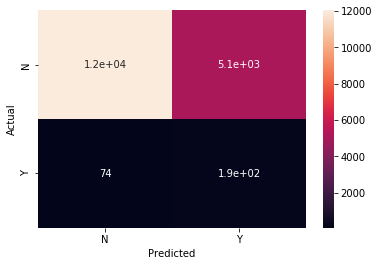

Recall Score:  0.7218045112781954
Precision Score:  0.036056338028169016
Area Under Curve:  0.7851915809807786


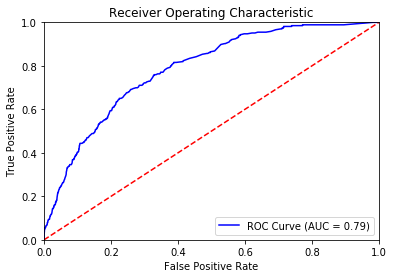

In [28]:
# 模型指標檢視：Accuracy, Recall, AUC
confusion_matrix = pd.crosstab(OBU['SAR'], OBU['pred'], rownames=['Actual'], 
                              colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)
print('Accuracy: ', metrics.accuracy_score(OBU['SAR'], OBU['pred']))
plt.show()

recall_score = metrics.recall_score(OBU['SAR'], OBU['pred'], pos_label='Y')
precision_score = metrics.precision_score(OBU['SAR'], OBU['pred'], pos_label='Y')
print('Recall Score: ', recall_score)
print('Precision Score: ', precision_score)


print('Area Under Curve: ', roc_auc_score(OBU['SAR'], OBU['pred_proba']))

fpr, tpr, threshold = metrics.roc_curve(OBU['SAR'], OBU['pred_proba'], pos_label='Y')
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='ROC Curve (AUC = %0.2f)' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##### 4.4 部分資料跑模型，確認變數係數

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2, stratify=y)

# class_weight='balanced'
logistic_regression = LogisticRegression(solver='liblinear', class_weight='balanced')
logistic_regression.fit(X_train, y_train)
y_pred=logistic_regression.predict(X_test)

In [31]:
# Weights & Intercept
print('Intercept: ', logistic_regression.intercept_, '\n')

for i in range(len(logistic_regression.coef_[0])):
    print(X.columns[i], ': ', logistic_regression.coef_[0][i])
print('----------------------------------')

Intercept:  [-2.87366357] 

CMFCUS1_FINANCIAL_ACT :  1.8574566235762429
LN_FG :  -0.08531456351807098
IX_FG :  1.1507215623472813
EB_FG :  -0.008709283102646131
CUST_THIRD :  2.7587211972109795
AMT_RANGE :  0.5496426335068026
OBU_ANNUAL_INCOME :  -0.003895882292344012
CMFCUS1_PURPOSE_E :  0.4925619339261829
CORP_TYPE_4 :  -5.089889174459544
----------------------------------


#### Appendix 1(提供變數預測能力之證明)

In [ ]:
# EY補充
# Appendix 1 主要為查看模型篩選之自變數與依變數在實際資料中的分佈
# 若未來有想要查看新的自變數與依變數之關係，則僅需要修改變數名稱及確認檔案名稱
# 
# 範例
# df為此次使用DataFrame；新增之自變數欄位名稱為"INDEPENDENT_VARIABLE"；依變數欄位名稱為"DEPENDENT_VARIABLE"
# pd.crosstab(df["DEPENDENT_VARIABLE", df["INDEPENDENT_VARIABLE"]])
# 欄位位置可對調，不影響結果，只影響呈現順序。


In [32]:
pd.crosstab(OBU['SAR'], OBU['CMFCUS1_FINANCIAL_ACT'])

CMFCUS1_FINANCIAL_ACT,0,1
SAR,,
N,3872,13285
Y,4,262


In [33]:
pd.crosstab(OBU['SAR'], OBU['IX_FG'])

IX_FG,0,1
SAR,,
N,14523,2634
Y,130,136


In [34]:
pd.crosstab(OBU['SAR'], OBU['EB_FG'])

EB_FG,0,1
SAR,,
N,7831,9326
Y,70,196


In [35]:
pd.crosstab(OBU['SAR'], OBU['REL_ADVERS_COUNT_THR_1'])

REL_ADVERS_COUNT_THR_1,0,1
SAR,,
N,17121,36
Y,257,9


In [36]:
pd.crosstab(OBU['SAR'], OBU['AMT_RANGE'])

AMT_RANGE,0,1,2,3
SAR,,,,
N,5355,6293,4162,1347
Y,11,83,128,44


In [37]:
pd.crosstab(OBU['SAR'], OBU['OBU_ANNUAL_INCOME'])

OBU_ANNUAL_INCOME,0,1,2,3
SAR,,,,
N,6527,6886,1271,2473
Y,33,115,40,78


In [38]:
pd.crosstab(OBU['SAR'], OBU['CMFCUS1_PURPOSE'])

CMFCUS1_PURPOSE,1,2,3,4,5,6,7,8,9,C,D,E,F,NA_TYPE
SAR,,,,,,,,,,,,,,
N,3160,55,2,1752,645,998,1,1,15,750,486,2951,118,6223
Y,70,2,0,32,6,10,0,0,0,27,3,85,3,28


In [39]:
pd.crosstab(OBU['SAR'], OBU['CORP_TYPE'])

CORP_TYPE,1,2,3,4,5,6,7,A,NA_TYPE,Z
SAR,,,,,,,,,,
N,3,1,28,1572,328,3,32,1,5043,10146
Y,0,0,0,4,1,0,0,0,9,252


#### Appendix 2 (確認FINAL_CRR及SAR之分佈狀況)

In [40]:
OBU.groupby(['FINAL_CRR', 'SAR'])['SAR'].count()

FINAL_CRR  SAR
H          N      7137
           Y       205
L          N       862
M          N      7775
Name: SAR, dtype: int64

#### Appendix 3
輸出機率數值供切分點分析(OLD)  
計算當機率切分為40%~60%時，F1-Score or Recall Score 之最佳化

In [43]:
for i in range(40, 61, 2):
    test['pred'] = np.where(test['pred_proba'] >= i/100, 'Y', 'N')
    print('機率切分為', i, '%:')
    print('Recall Score: ', metrics.recall_score(test['SAR'], test['pred'], pos_label='Y'))
    print('Accuracy: ', metrics.accuracy_score(test['SAR'], test['pred']))
    print('F1 Score: ', metrics.f1_score(test['SAR'], test['pred'], pos_label='Y'))
    print('-------------------------------------------')

機率切分為 40 %:
Recall Score:  0.8157894736842105
Accuracy:  0.6084486024220858
F1 Score:  0.05981256890848953
-------------------------------------------
機率切分為 42 %:
Recall Score:  0.8157894736842105
Accuracy:  0.6141881421110027
F1 Score:  0.060648406931246505
-------------------------------------------
機率切分為 44 %:
Recall Score:  0.8045112781954887
Accuracy:  0.6218791252941515
F1 Score:  0.061003420752565575
-------------------------------------------
機率切分為 46 %:
Recall Score:  0.793233082706767
Accuracy:  0.6264133616483958
F1 Score:  0.06088587505410474
-------------------------------------------
機率切分為 48 %:
Recall Score:  0.7631578947368421
Accuracy:  0.662400275497905
F1 Score:  0.06456743002544528
-------------------------------------------
機率切分為 50 %:
Recall Score:  0.7218045112781954
Accuracy:  0.7011421683980945
F1 Score:  0.06868181005186909
-------------------------------------------
機率切分為 52 %:
Recall Score:  0.6992481203007519
Accuracy:  0.7255926074728807
F1 Score:  0.07219